In [1]:
import itertools
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from IPython.display import display
from sklearn import svm, datasets
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, accuracy_score, f1_score, roc_curve, auc, precision_score
import scipy.stats

import seaborn as sns
from MutBkgd import MutationBackground

%matplotlib inline
sns.set_style("whitegrid", {'axes.grid' : False})

In [2]:
%%javascript
IPython.OutputArea.auto_scroll_threshold = 9999; 

<IPython.core.display.Javascript object>

In [18]:
prefix = 'HS.'

s_het = np.load('../data/gene/s_het.npy').item()
prec = np.load('../data/gene/prec.npy').item()
pli = np.load('../data/gene/pli.npy').item()
lofz = np.load('../data/gene/lofz.npy').item()

HS_gene = set(gene for gene, pli_score in pli.iteritems() if pli_score < 0.5)
HIS_gene = set(gene for gene, pli_score in pli.iteritems() if pli_score >= 0.5)
prec_5 = set(gene for gene, pli_score in prec.iteritems() if pli_score >0.5)
lofz3 = set(gene for gene, score in lofz.iteritems() if score >= 3)

if prefix == 'HIS.':
    geneset = HIS_gene 
elif prefix == 'HS.':
    geneset = HS_gene
else:
    geneset = geneset

# compare confusion matrix

In [4]:
def plot_multi_confusion_matrix(df, y_true, dataset, save=False,
                                class_names = ['damage_negative', 'damage_positive']):
    '''take a dataframe with predictors and y_true value, output multiple confusion matrix plot
    '''
    
    # 'M-CAP_rankscore', 0.4815 is 0.025 cutoff 0.642 is 0.05 cutoff
    col_dict={'cadd15':('CADD_phred', 15), 'cadd20':('CADD_phred', 20),
              'cadd25':('CADD_phred', 25), 'cadd30':('CADD_phred', 30),
              'eigen_pred10':('Eigen-phred', 10), 'eigen_pred15':('Eigen-phred', 15),
              'eigen_pc_pred10':('Eigen-PC-phred', 10), 
              'MetaSVM>0':('MetaSVM_rankscore', 0.82271),'MetaLR>0':('MetaLR_rankscore', 0.81122), 
              'M_CAP>0.025':('M-CAP_rankscore', 0.4815), 'M_CAP>0.05':('M-CAP_rankscore', 0.642), 
              'PP2-HVAR':('Polyphen2_HVAR_rankscore', 0.6280),'FATHMM':('FATHMM_converted_rankscore', 0.8235),
              'all_missense':('cnn_prob', 0.0),'cnn_0.05':('cnn_prob', 0.05),
              'cnn_0.1':('cnn_prob', 0.1), 'cnn_0.2':('cnn_prob', 0.2),
              'cnn_0.3':('cnn_prob', 0.3), 'cnn_0.4':('cnn_prob', 0.4),
              'cnn_0.5':('cnn_prob', 0.5), 'cnn_0.6':('cnn_prob', 0.6),
              'cnn_0.7':('cnn_prob', 0.7), 'cnn_0.8':('cnn_prob', 0.8),
              'cnn_best_0.56':('cnn_prob', 0.56)}
    
    y_preds, y_algos = [], []
    for key, (col, threshold) in col_dict.items():
        y_algos.append(key)
        y_preds.append(convert2binary(df, col, threshold))

    infos = []
    for y_pred, y_algo in zip(y_preds, y_algos):
        # Compute confusion matrix
        accuracy = accuracy_score(y_true, y_pred)
        f1 = f1_score(y_true, y_pred)
        cnf_matrix = confusion_matrix(y_true, y_pred)
        fdr = 1 - precision_score(y_true, y_pred)
        np.set_printoptions(precision=2)

        title = '../figure/' + dataset + y_algo + '.png'
        # Plot non-normalized confusion matrix
        figure_title = 'Confusion matrix, without normalization\n{}\n{}\n accuracy: {:.2f}\n f1: {:.2f}\n'.format(
            dataset, y_algo, accuracy, f1)
        fig = plt.figure(figsize = (5,5))
        plot_confusion_matrix(cnf_matrix, classes=class_names,
                              title=figure_title)
        
        if save:
            infos.append([y_algo, accuracy, f1, fdr])
            fig.savefig(title)
            plt.close()
        else:
            plt.show()
    labels = ['Col', 'accuracy', 'f1', 'FDR']            
    df = pd.DataFrame(infos,columns=labels)
    display(df)

def convert2binary(df, col, threshold):
    '''take a dataframe, col to compare, threshold, return the binary vector
        convert to more elegent lambda function way 
        http://stackoverflow.com/questions/28719067/roc-curve-and-cut-off-point-python
    '''
    values = np.array(df[col].values)
    index = values >= threshold
    values[index] = 1
    values[~index] = 0
    return values

def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    #plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=0)
    plt.yticks(tick_marks, classes, rotation=45)

#     if normalize:
#         cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
#         print("Normalized confusion matrix")
#     else:
#         print('Confusion matrix, without normalization')
#     print(cm)

    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, cm[i, j],
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

In [7]:
class_names = ['damage_negative', 'damage_positive'] # 0 for 'damage_negative', 1 for 'damage_positive'

validation = '../data/output/output_data_mode5.csv'
fname = validation
df = pd.read_csv(fname)
df = df[df.training==0]
y_true = df.pop('target')
dataset = 'validation(20% HGMD,DiscovEHR)'
plot_multi_confusion_matrix(df, y_true, dataset, save=True)

/Users/hongjian/Library/Enthought/Canopy/edm/envs/User/lib/python2.7/site-packages/IPython/core/interactiveshell.py:2717: DtypeWarning: Columns (58,62,64) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


,Col,accuracy,f1,FDR
0,all_missense,0.503947,0.670166,0.496053
1,PP2-HVAR,0.728037,0.694333,0.199340
2,cnn_0.7,0.943086,0.942404,0.038391
3,eigen_pred10,0.601732,0.385462,0.133392
4,FATHMM,0.790553,0.772759,0.147516
5,cnn_0.05,0.884899,0.896898,0.182536
6,cadd20,0.807614,0.829670,0.250967
7,cnn_0.6,0.947161,0.947154,0.045186
8,cnn_0.5,0.950344,0.951042,0.054890
9,cnn_0.4,0.947543,0.948909,0.068193


In [18]:
fnames = ['../data/metaSVM/metaSVM_test1.anno.rare.'+prefix+'reformat.cnn.csv',
          '../data/metaSVM/metaSVM_test2.anno.rare.'+prefix+'reformat.cnn.csv',
          '../data/metaSVM/metaSVM_addtest1.anno.rare.'+prefix+'reformat.cnn.csv',
          '../data/metaSVM/metaSVM_addtest2.anno.rare.'+prefix+'reformat.cnn.csv',
          '../data/metaSVM/metaSVM_train.anno.rare.'+prefix+'reformat.cnn.csv']

for fname in fnames:
    df = pd.read_csv(fname)
    y_true = df.pop('target')
    dataset = fname.split('_')[-1].split('.')[0]
    print dataset
    plot_multi_confusion_matrix(df, y_true, dataset, save=True)


test1


,Col,accuracy,f1,FDR
0,all_missense,0.736264,0.848101,0.263736
1,PP2-HVAR,0.736264,0.800000,0.094340
2,cnn_0.7,0.802198,0.844828,0.000000
3,eigen_pred10,0.439560,0.385542,0.000000
4,FATHMM,0.637363,0.685714,0.052632
5,cnn_0.05,0.901099,0.932331,0.060606
6,cadd20,0.868132,0.914286,0.123288
7,cnn_0.6,0.802198,0.847458,0.019608
8,cnn_0.5,0.846154,0.885246,0.018182
9,cnn_0.4,0.868132,0.903226,0.017544


test2


,Col,accuracy,f1,FDR
0,all_missense,0.398489,0.569885,0.601511
1,PP2-HVAR,0.706509,0.661755,0.388109
2,cnn_0.7,0.895002,0.868892,0.135291
3,eigen_pred10,0.631538,0.252358,0.340862
4,FATHMM,0.843084,0.808057,0.211743
5,cnn_0.05,0.746416,0.754823,0.386045
6,cadd20,0.612360,0.651818,0.492412
7,cnn_0.6,0.887834,0.863797,0.163172
8,cnn_0.5,0.882991,0.861531,0.184816
9,cnn_0.4,0.869430,0.849822,0.215549


addtest1


,Col,accuracy,f1,FDR
0,all_missense,0.716757,0.835013,0.283243
1,PP2-HVAR,0.693188,0.762901,0.144925
2,cnn_0.7,0.927204,0.948355,0.035227
3,eigen_pred10,0.382282,0.268725,0.112998
4,FATHMM,0.883076,0.917126,0.067911
5,cnn_0.05,0.873966,0.918557,0.144467
6,cadd20,0.730130,0.818769,0.210691
7,cnn_0.6,0.933305,0.953333,0.043759
8,cnn_0.5,0.934726,0.954743,0.051031
9,cnn_0.4,0.930965,0.952616,0.062444


addtest2


,Col,accuracy,f1,FDR
0,all_missense,0.635791,0.777350,0.364209
1,PP2-HVAR,0.740488,0.788811,0.182743
2,cnn_0.7,0.910653,0.928564,0.055686
3,eigen_pred10,0.451063,0.280358,0.158058
4,FATHMM,0.844529,0.873788,0.097072
5,cnn_0.05,0.834427,0.883622,0.201234
6,cadd20,0.743243,0.822075,0.265236
7,cnn_0.6,0.912490,0.931173,0.068731
8,cnn_0.5,0.912359,0.931948,0.079678
9,cnn_0.4,0.906849,0.928729,0.095778


train


,Col,accuracy,f1,FDR
0,all_missense,0.664720,0.798597,0.335280
1,PP2-HVAR,0.769853,0.818335,0.139153
2,cnn_0.7,0.924520,0.942426,0.044143
3,eigen_pred10,0.470965,0.365571,0.098938
4,FATHMM,0.857127,0.889641,0.085770
5,cnn_0.05,0.856228,0.901946,0.175028
6,cadd20,0.777828,0.847893,0.221987
7,cnn_0.6,0.929462,0.947022,0.054414
8,cnn_0.5,0.930024,0.948018,0.063623
9,cnn_0.4,0.928451,0.947316,0.072250


# ROC

In [5]:
def plot_roc(df, y_true, label):
    
    fpr = dict()
    tpr = dict()
    roc_auc = dict()
    algos = ['cnn_prob', 'MetaSVM_rankscore', 'MetaLR_rankscore', 'M-CAP_rankscore', 
             'DANN_rankscore','CADD_phred', 'Eigen-phred','Polyphen2_HVAR_rankscore', 
             'MutationTaster_converted_rankscore', 'FATHMM_converted_rankscore', 
             'fathmm-MKL_coding_rankscore']
    for algo in algos:
        index = (df[algo]!= -1) & (df[algo]!= 0)
        y_score = df.ix[index][algo].values
        y_true_nomissing = y_true[index]

        fpr[algo], tpr[algo], _ = roc_curve(y_true_nomissing, y_score)
        roc_auc[algo] = auc(fpr[algo], tpr[algo])
    # jump comes from missing value

    plt.figure(figsize = (10,10))
    lw = 2
    for algo in algos:
        plt.plot(fpr[algo], tpr[algo], lw=lw, 
                 label='{} ROC curve (area = {:.2f})'.format(algo, roc_auc[algo]))

        plt.plot([0, 1], [0, 1], color='navy', lw=lw, linestyle='--')
        plt.xlim([0.0, 1.0])
        plt.ylim([0.0, 1.05])
        plt.xlabel('False Positive Rate')
        plt.ylabel('True Positive Rate')
        
    total = len(y_true)
    pos = sum(y_true)
    neg = total - pos
    
    plt.title('Receiver operating characteristic of {}: {} positive, {} negative'.format(label, pos, neg))
    plt.legend(loc="lower right", fontsize = 'medium')
    plt.show()
    
def Find_Optimal_Cutoff(target, predicted):
    """ Find the optimal probability cutoff point for a classification model related to event rate
    Parameters based on distance
    """
    fpr, tpr, threshold = roc_curve(target, predicted)
    i = np.arange(len(tpr)) 
    roc = pd.DataFrame({'dist' : pd.Series(abs(tpr-fpr), index=i), 'threshold' : pd.Series(threshold, index=i),
                        'fpr':pd.Series(fpr, index=i), 'tpr':pd.Series(tpr, index=i)})
    roc_t = roc.ix[roc.dist.argsort()]
    return roc_t.tail(3)

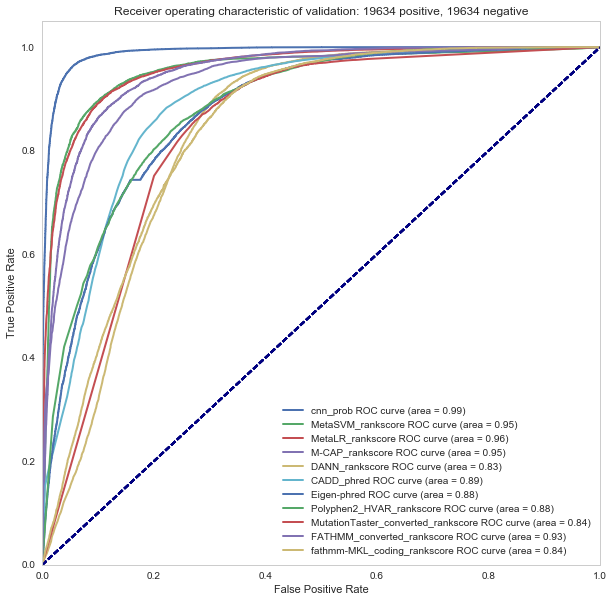

,dist,fpr,threshold,tpr
6344,0.908271,0.054650,0.474027,0.962921
6347,0.908322,0.054752,0.473595,0.963074
6349,0.908373,0.054803,0.472951,0.963176


In [8]:
class_names = ['damage_negative', 'damage_positive']
fname = validation
df = pd.read_csv(fname)
y_true = df.pop('target')
plot_roc(df, y_true, label = 'validation')
Find_Optimal_Cutoff(y_true, df['cnn_prob'])

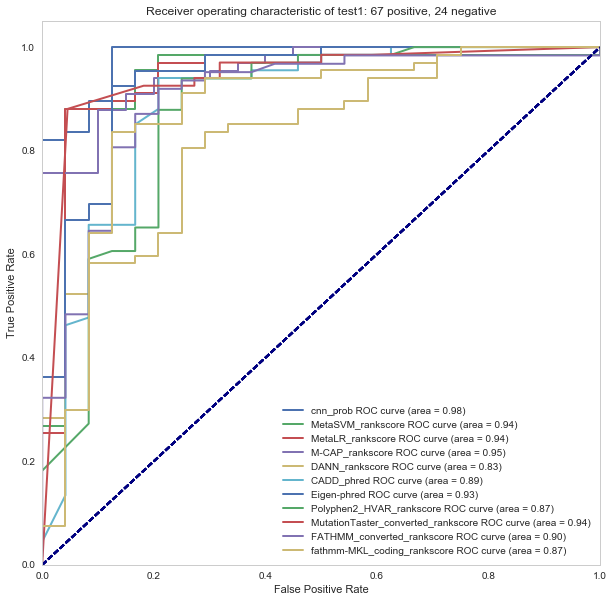

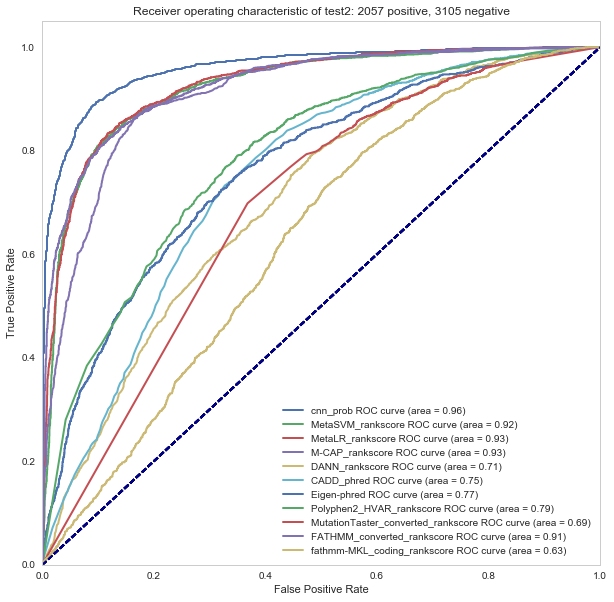

/Users/hongjian/Library/Enthought/Canopy/edm/envs/User/lib/python2.7/site-packages/IPython/core/interactiveshell.py:2717: DtypeWarning: Columns (58) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


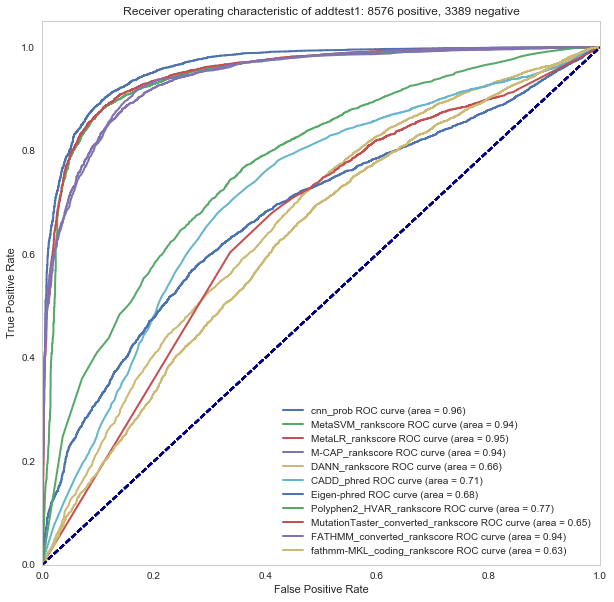

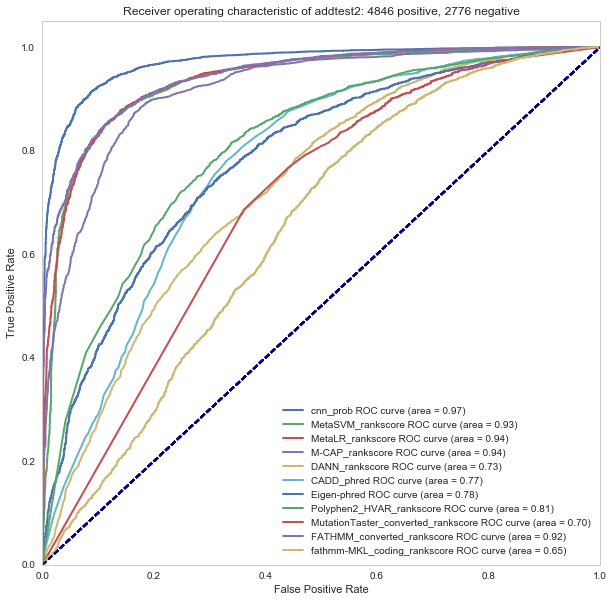

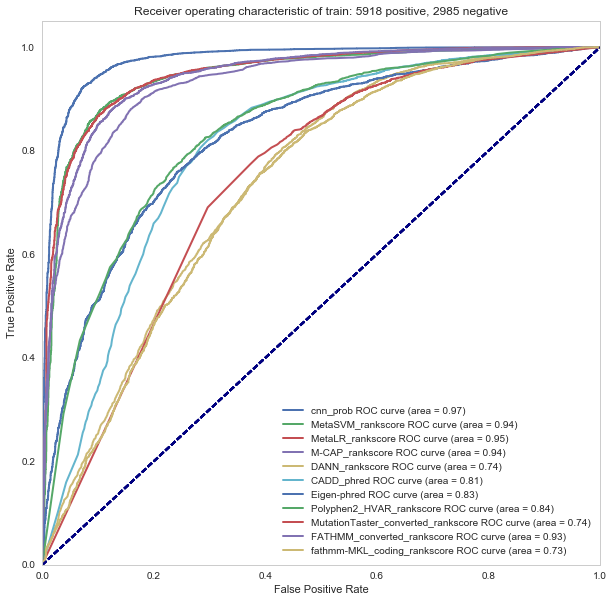

In [9]:
# metaSVM test
fnames = ['../data/metaSVM/metaSVM_test1.anno.rare.'+prefix+'reformat.cnn.csv',
          '../data/metaSVM/metaSVM_test2.anno.rare.'+prefix+'reformat.cnn.csv',
          '../data/metaSVM/metaSVM_addtest1.anno.rare.'+prefix+'reformat.cnn.csv',
          '../data/metaSVM/metaSVM_addtest2.anno.rare.'+prefix+'reformat.cnn.csv',
          '../data/metaSVM/metaSVM_train.anno.rare.'+prefix+'reformat.cnn.csv']
labels = []
for fname in fnames:
    labels.append(fname.split('_')[-1].split('.')[0])
    
for fname, lable in zip(fnames, labels):
    df = pd.read_csv(fname)
    y_true = df.pop('category')
    index = y_true == 'TP'
    y_true[index] = 1
    y_true[~index] = 0
    y_true = y_true.astype(int)
    plot_roc(df, y_true, lable)

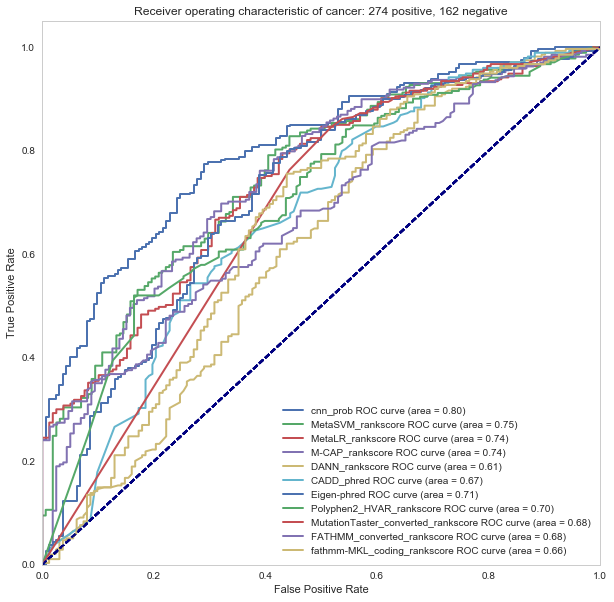

In [10]:
class_names = ['cancer_passengers', 'cancer_hotspot']
fname = '../data/cancer_hotspots/cancer.'+prefix+'reformat.cnn.csv'
df = pd.read_csv(fname)
y_true = df.pop('target')
plot_roc(df, y_true, label = 'cancer')

# enrichment

In [20]:
fname = '../data/gene/mis_rate_hongjian_onegene_0526.txt'
mutation_bkgrd = MutationBackground(fname)

def display_enrichment(case_info, control_info, case_disease, geneset, sort_key='Col'):
    
    print case_disease
    df_case, case_disease, disease_size = case_info 
    df_control, control_disease, disease_size = control_info 
    case_size = 0.0
    for disease in case_disease:
        if disease in disease_size:
            case_size += disease_size[disease]
    control_size = 0.0
    for disease in control_disease:
        control_size += disease_size[disease]
    print 'case size:{} control size:{}'.format(case_size, control_size)
    
    # add PDmis columns
    df_case['PDmis'] = np.where((df_case['CADD_phred'] >= 15) & (df_case['Polyphen2_HDIV_rankscore'] >= 0.52875) , 1, 0)
    df_control['PDmis'] = np.where((df_control['CADD_phred'] >= 15) & (df_control['Polyphen2_HDIV_rankscore'] >= 0.52875) , 1, 0)
    # 'M-CAP_rankscore', 0.4815 is 0.025 cutoff 0.642 is 0.05 cutoff
    col_dict={'cadd15':('CADD_phred', 15), 'cadd20':('CADD_phred', 20),
              'cadd25':('CADD_phred', 25), 'cadd30':('CADD_phred', 30),
              'eigen_pred10':('Eigen-phred', 10), 'eigen_pred15':('Eigen-phred', 15),
              'eigen_pc_pred10':('Eigen-PC-phred', 10), 
              'MetaSVM>0':('MetaSVM_rankscore', 0.82271),'MetaLR>0':('MetaLR_rankscore', 0.81122), 
              'M_CAP>0.025':('M-CAP_rankscore', 0.4815), 'M_CAP>0.05':('M-CAP_rankscore', 0.642), 
              'PP2-HVAR':('Polyphen2_HVAR_rankscore', 0.6280),'FATHMM':('FATHMM_converted_rankscore', 0.8235),
              'all_missense':('cnn_prob', 0.0),'cnn_0.05':('cnn_prob', 0.05),
              'cnn_0.1':('cnn_prob', 0.1), 'cnn_0.2':('cnn_prob', 0.2),
              'cnn_0.3':('cnn_prob', 0.3), 'cnn_0.4':('cnn_prob', 0.4),
              'cnn_0.5':('cnn_prob', 0.5), 'cnn_0.6':('cnn_prob', 0.6),
              'cnn_0.7':('cnn_prob', 0.7), 'cnn_0.8':('cnn_prob', 0.8),
              'cnn_best_0.56':('cnn_prob', 0.56)}

    
    infos = [] 
    for col_name, (col, threshold) in col_dict.items():
        case_count = np.sum(convert2binary(df_case, col, threshold))
        control_count = np.sum(convert2binary(df_control, col, threshold))
        total_counts = case_count + control_count
        control_count = max(control_count, 1)
        enrich = float(case_count) / case_size / (float(control_count) / control_size)
        pvalue = scipy.stats.binom_test(case_count, total_counts,
                                            case_size / (case_size + control_size))
        risk_gene = case_count * (enrich - 1) / enrich
        enrich = max(enrich, 1)
        tpr = (enrich - 1) / enrich
        
        exp = mutation_bkgrd.expectation(geneset, col_name) * case_size
        if exp == 0: # use control instead
            exp = case_count - risk_gene
            
        exp_enr = case_count / exp
        exp_risk_gene = case_count * (exp_enr - 1) / exp_enr
        exp_tpr = (exp_enr - 1) / exp_enr
        
        
        infos.append([col_name, case_count, control_count, 
                      enrich, pvalue, risk_gene, tpr,
                      exp, exp_enr, exp_risk_gene, exp_tpr])
        
    
    labels = ['Col', 'Case', 'Control', 'enrich', 'pvalue', '# risk gene', 'true positive rate',
              'exp', 'exp_enr', 'exp_risk_gene', 'exp_tpr']            
    df = pd.DataFrame(infos,columns=labels)
    df = df.sort_values(by=sort_key, ascending=True)
    display(df)
    plot_rate_vs_riskvariants(df, title=','.join(case_disease))
    return df

def plot_rate_vs_riskvariants(df, title):
    x = list(df['true positive rate'])
    y = list(df['# risk gene'])
    
#     x = list(df['exp_tpr'])
#     y = list(df['exp_risk_gene'])
    methods = list(df['Col'])
    fig, ax = plt.subplots(figsize = (15,10))
    ax.scatter(x, y, s=100)
    for i, txt in enumerate(methods):
        if 'cnn' in txt:
            color = 'red'
        elif 'all_missense' in txt:
            color = 'blue'
        else:
            color = 'black'
        ax.annotate(txt, (x[i],y[i]), fontsize=15, color=color)
    ax.set_xlim(0)
    ax.set_ylim(0)
    ax.set_xlabel('true positive rate', fontsize=15)
    ax.set_ylabel('# risk gene', fontsize=15)
    
    case_variants, control_variants = df.ix[df['Col']=='all_missense'][['Case', 'Control']].values[0]
    
    ax.set_title('{}: {} variants in cases, {} variants in controls'.format(title, 
                                            case_variants, control_variants), fontsize=15)  

['ASD']
case size:3953.0 control size:1789.0
do not have rate for cnn_0.7
do not have rate for cnn_0.05
do not have rate for cnn_0.6
do not have rate for cnn_0.5
do not have rate for cnn_0.4
do not have rate for cnn_0.1
do not have rate for cnn_0.3
do not have rate for cnn_0.2
do not have rate for cnn_best_0.56
do not have rate for cnn_0.8


,Col,Case,Control,enrich,pvalue,# risk gene,true positive rate,exp,exp_enr,exp_risk_gene,exp_tpr
4,FATHMM,272.0,115.0,1.070421,0.583168,17.894354,0.065788,273.809662,0.993391,-1.809662,-0.006653
21,M_CAP>0.025,772.0,344.0,1.015646,0.821119,11.892677,0.015405,826.526371,0.934029,-54.526371,-0.070630
17,M_CAP>0.05,527.0,224.0,1.064746,0.454178,32.046395,0.060809,572.840127,0.919977,-45.840127,-0.086983
20,MetaLR>0,323.0,131.0,1.115873,0.310889,33.540525,0.103841,309.118035,1.044908,13.881965,0.042978
18,MetaSVM>0,303.0,131.0,1.046779,0.678800,13.540525,0.044688,288.569513,1.050007,14.430487,0.047625
1,PP2-HVAR,556.0,254.0,1.000000,0.909407,-5.242035,0.000000,553.784504,1.004001,2.215496,0.003985
0,all_missense,1679.0,757.0,1.003780,0.947682,6.321968,0.003765,1597.987885,1.050696,81.012115,0.048250
19,cadd15,1230.0,542.0,1.027045,0.626058,32.389044,0.026333,1151.023868,1.068614,78.976132,0.064208
6,cadd20,1089.0,468.0,1.053090,0.366571,54.900503,0.050414,1004.634900,1.083976,84.365100,0.077470
11,cadd25,659.0,275.0,1.084517,0.273447,51.356065,0.077930,560.156452,1.176457,98.843548,0.149990


['DDD_new']
case size:4293.0 control size:1789.0
do not have rate for cnn_0.7
do not have rate for cnn_0.05
do not have rate for cnn_0.6
do not have rate for cnn_0.5
do not have rate for cnn_0.4
do not have rate for cnn_0.1
do not have rate for cnn_0.3
do not have rate for cnn_0.2
do not have rate for cnn_best_0.56
do not have rate for cnn_0.8


,Col,Case,Control,enrich,pvalue,# risk gene,true positive rate,exp,exp_enr,exp_risk_gene,exp_tpr
4,FATHMM,333.0,115.0,1.206690,0.087016,57.038569,0.171287,297.360203,1.119854,35.639797,0.107026
21,M_CAP>0.025,935.0,344.0,1.132668,0.049525,109.515372,0.117129,897.616420,1.041648,37.383580,0.039982
17,M_CAP>0.05,640.0,224.0,1.190643,0.025040,102.475126,0.160117,622.110464,1.028756,17.889536,0.027952
20,MetaLR>0,409.0,131.0,1.301072,0.008150,94.643935,0.231403,335.705471,1.218330,73.294529,0.179204
18,MetaSVM>0,389.0,131.0,1.237450,0.034256,74.643935,0.191887,313.389557,1.241267,75.610443,0.194371
1,PP2-HVAR,681.0,254.0,1.117282,0.141123,71.485187,0.104971,601.415855,1.132328,79.584145,0.116864
0,all_missense,1843.0,757.0,1.014563,0.746886,26.453885,0.014354,1735.431821,1.061984,107.568179,0.058366
19,cadd15,1407.0,542.0,1.081793,0.123294,106.381778,0.075609,1250.024151,1.125578,156.975849,0.111568
6,cadd20,1233.0,468.0,1.097910,0.088573,109.956959,0.089178,1091.044175,1.130110,141.955825,0.115130
11,cadd25,748.0,275.0,1.133492,0.080094,88.092230,0.117770,608.335859,1.229584,139.664141,0.186717


['CHD_yale']
case size:2645.0 control size:1789.0
do not have rate for cnn_0.7
do not have rate for cnn_0.05
do not have rate for cnn_0.6
do not have rate for cnn_0.5
do not have rate for cnn_0.4
do not have rate for cnn_0.1
do not have rate for cnn_0.3
do not have rate for cnn_0.2
do not have rate for cnn_best_0.56
do not have rate for cnn_0.8


,Col,Case,Control,enrich,pvalue,# risk gene,true positive rate,exp,exp_enr,exp_risk_gene,exp_tpr
4,FATHMM,207.0,115.0,1.217467,0.099387,36.974846,0.178622,183.209349,1.129855,23.790651,0.114931
21,M_CAP>0.025,575.0,344.0,1.130561,0.074741,66.403018,0.115484,553.038768,1.039710,21.961232,0.038193
17,M_CAP>0.05,381.0,224.0,1.150434,0.097536,49.820570,0.130763,383.294241,0.994014,-2.294241,-0.006022
20,MetaLR>0,235.0,131.0,1.213336,0.078768,41.319173,0.175826,206.834607,1.136174,28.165393,0.119853
18,MetaSVM>0,231.0,131.0,1.192684,0.108331,37.319173,0.161555,193.085343,1.196362,37.914657,0.164133
1,PP2-HVAR,412.0,254.0,1.097105,0.252239,36.466182,0.088510,370.543894,1.111879,41.456106,0.100622
0,all_missense,1177.0,757.0,1.051636,0.286425,57.790945,0.049100,1069.232976,1.100789,107.767024,0.091561
19,cadd15,851.0,542.0,1.061977,0.286881,49.664058,0.058360,770.163960,1.104960,80.836040,0.094989
6,cadd20,765.0,468.0,1.105606,0.092247,73.071548,0.095518,672.213334,1.138032,92.786666,0.121290
11,cadd25,459.0,275.0,1.128924,0.114181,52.418111,0.114201,374.807442,1.224629,84.192558,0.183426


['SSC_yale']
case size:1789.0 control size:1789.0
do not have rate for cnn_0.7
do not have rate for cnn_0.05
do not have rate for cnn_0.6
do not have rate for cnn_0.5
do not have rate for cnn_0.4
do not have rate for cnn_0.1
do not have rate for cnn_0.3
do not have rate for cnn_0.2
do not have rate for cnn_best_0.56
do not have rate for cnn_0.8


,Col,Case,Control,enrich,pvalue,# risk gene,true positive rate,exp,exp_enr,exp_risk_gene,exp_tpr
4,FATHMM,115.0,115.0,1.0,1.0,0.0,0.0,123.917401,0.928038,-8.917401,-0.077543
21,M_CAP>0.025,344.0,344.0,1.0,1.0,0.0,0.0,374.059114,0.919641,-30.059114,-0.087381
17,M_CAP>0.05,224.0,224.0,1.0,1.0,0.0,0.0,259.248922,0.864034,-35.248922,-0.157361
20,MetaLR>0,131.0,131.0,1.0,1.0,0.0,0.0,139.896829,0.936404,-8.896829,-0.067915
18,MetaSVM>0,131.0,131.0,1.0,1.0,0.0,0.0,130.597232,1.003084,0.402768,0.003075
1,PP2-HVAR,254.0,254.0,1.0,1.0,0.0,0.0,250.624963,1.013466,3.375037,0.013288
0,all_missense,757.0,757.0,1.0,1.0,0.0,0.0,723.197654,1.046740,33.802346,0.044653
19,cadd15,542.0,542.0,1.0,1.0,0.0,0.0,520.916190,1.040474,21.083810,0.038900
6,cadd20,468.0,468.0,1.0,1.0,0.0,0.0,454.665276,1.029329,13.334724,0.028493
11,cadd25,275.0,275.0,1.0,1.0,0.0,0.0,253.508701,1.084775,21.491299,0.078150


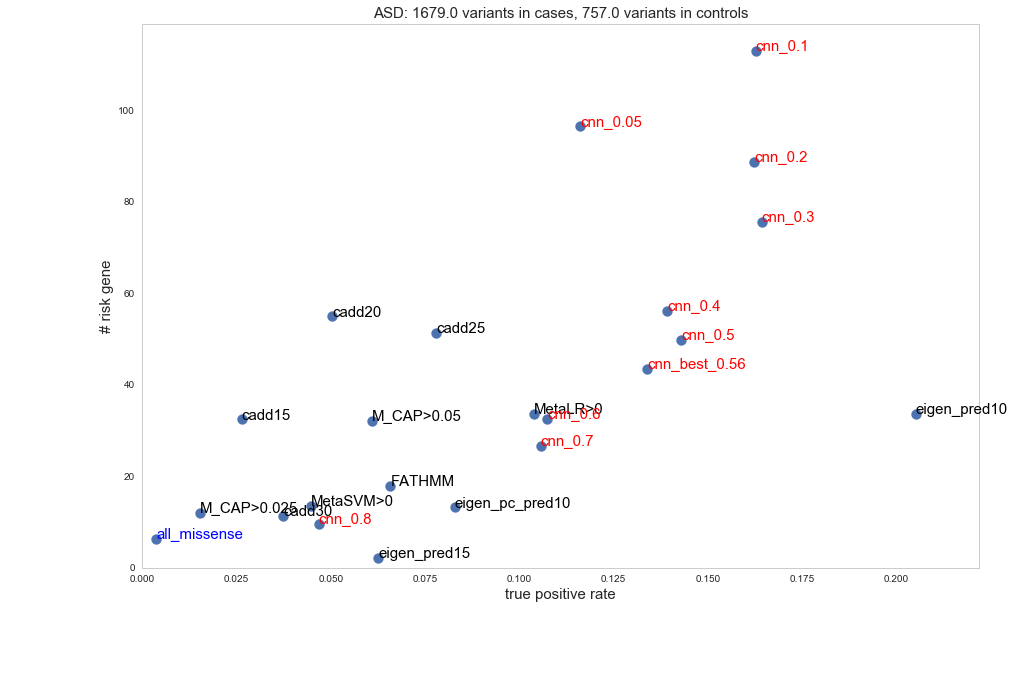

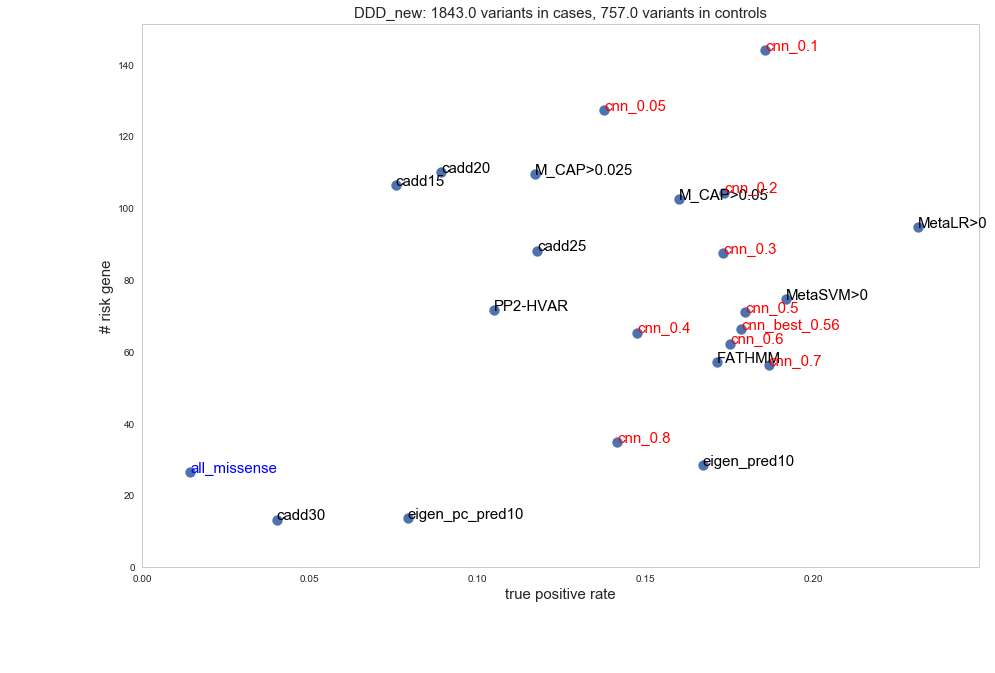

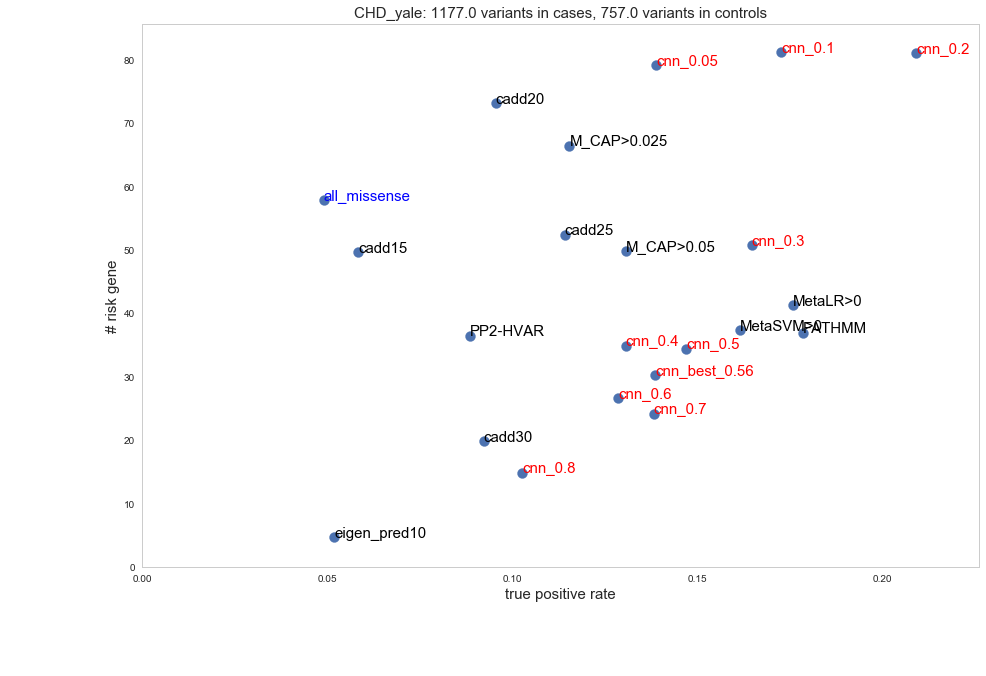

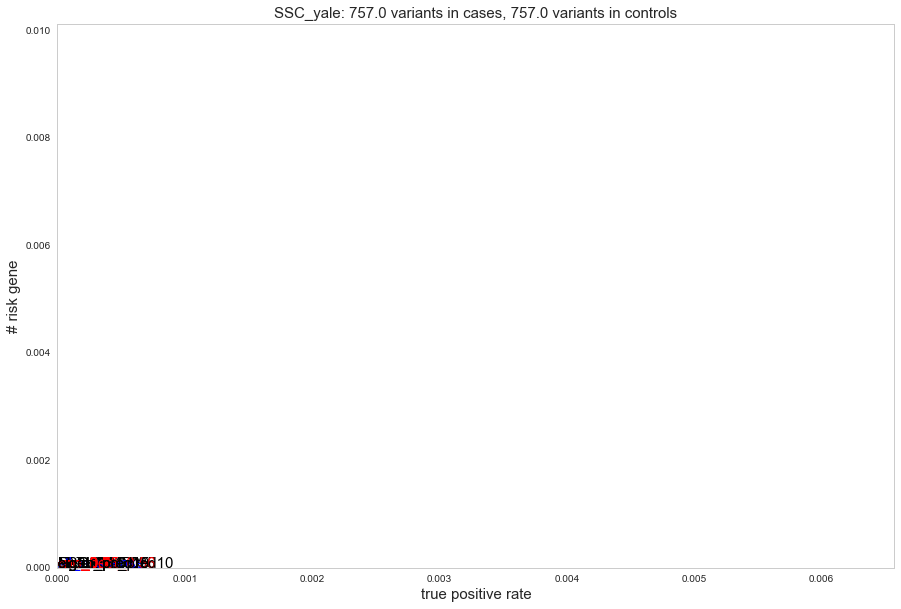

In [22]:


disease_size = {'CHD':2779, 'CDH':307,'CDH_MGH':80,
                'ASD':3953, 'EE':264, 'ID':192,
                'DDD_new':4293, 'DDD':1133, 'SSC':1911,
                'CHD_yale':2645, 'SSC_yale':1789 } 




fname = '../data/case_control/ssc_yale.anno.rare.'+prefix+'reformat.cnn.csv'
control_disease = ['SSC_yale']

fname = '../data/case_control/control_1911.anno.rare.'+prefix+'reformat.cnn.csv'
control_disease = ['SSC']

df_control = pd.read_csv(fname)
index = df_control['disease'].isin(control_disease) & df_control['genename'].isin(geneset) 
#index = index & (df_control['prec'] >=0.8)

df_control = df_control[index]
control_info = (df_control, control_disease, disease_size)



# data is a little more than ANNOVAR annotatoin, do a comparison later
case_diseases = [['CHD'], ['CDH'], ['ASD'],['EE'], ['ID'], ['DDD'], 
                 ['CHD', 'CDH', 'ASD','EE', 'ID', 'DDD']]

case_diseases = [['ASD']]

for case_disease in case_diseases:

    fname = '../data/case_control/case.anno.rare.'+prefix+'reformat.cnn.csv'
    df_case = pd.read_csv(fname)
    index = df_case['disease'].isin(case_disease) & df_case['genename'].isin(geneset) 
    
    df_case = df_case[index]
    case_info = (df_case, case_disease, disease_size)
    df = display_enrichment(case_info, control_info, case_disease, geneset)

fname = '../data/case_control/DDD_new_0.2.anno.rare.'+prefix+'reformat.cnn.csv'
case_disease = ['DDD_new']
df_case = pd.read_csv(fname)
index =  df_case['genename'].isin(geneset) 
df_case = df_case[index]
case_info = (df_case, case_disease, disease_size)
df = display_enrichment(case_info, control_info, case_disease, geneset)

    
fname = '../data/case_control/chd_yale.anno.rare.'+prefix+'reformat.cnn.csv'
case_disease = ['CHD_yale']
df_case = pd.read_csv(fname)
index =  df_case['genename'].isin(geneset) 
df_case = df_case[index]
case_info = (df_case, case_disease, disease_size)
df = display_enrichment(case_info, control_info, case_disease, geneset)


fname = '../data/case_control/ssc_yale.anno.rare.'+prefix+'reformat.cnn.csv'
case_disease = ['SSC_yale']
df_case = pd.read_csv(fname)
index =  df_case['genename'].isin(geneset) 
df_case = df_case[index]
case_info = (df_case, case_disease, disease_size)
df = display_enrichment(case_info, control_info, case_disease, geneset)

In [14]:
mutation_bkgrd.rate['GATA4']

{'FATHMM': 2.28996826263e-05,
 'M_CAP>0.025': 2.25417824544e-05,
 'M_CAP>0.05': 2.23268122485e-05,
 'MetaLR>0': 2.16112274644e-05,
 'MetaSVM>0': 2.10965714918e-05,
 'PP2-HVAR': 8.64364379661e-06,
 'all_missense': 2.29145989512e-05,
 'cadd15': 1.75530007436e-05,
 'cadd20': 1.56586872113e-05,
 'cadd25': 8.70931136226e-06,
 'cadd30': 4.09290586572e-06,
 'eigen_pc_pred10': 2.43839090138e-06,
 'eigen_pred10': 2.5614655022e-06,
 'eigen_pred15': 8.72234785152e-07}